In [377]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [351]:
data = yf.download('AAPL', '2018-01-01', '2025-01-01')
data.reset_index(inplace=True)
df=data
df.info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1761 non-null   datetime64[ns]
 1   (Close, AAPL)   1761 non-null   float64       
 2   (High, AAPL)    1761 non-null   float64       
 3   (Low, AAPL)     1761 non-null   float64       
 4   (Open, AAPL)    1761 non-null   float64       
 5   (Volume, AAPL)  1761 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.7 KB


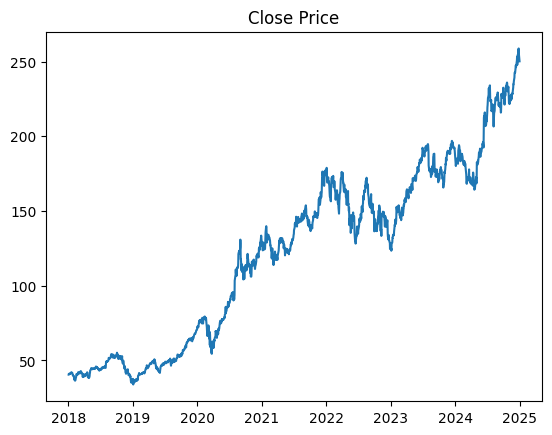

In [352]:
plt.title("Close Price")
plt.plot(df.Date, df.Close)

In [353]:
print(df.describe())

Price                            Date        Close         High          Low  \
Ticker                                        AAPL         AAPL         AAPL   
count                            1761  1761.000000  1761.000000  1761.000000   
mean    2021-07-01 15:36:17.172061440   122.267030   123.479697   120.916910   
min               2018-01-02 00:00:00    33.915264    34.757242    33.869945   
25%               2019-10-02 00:00:00    54.279202    54.983885    53.891756   
50%               2021-07-01 00:00:00   131.876663   133.369331   130.507723   
75%               2023-03-31 00:00:00   169.228806   170.791455   167.787743   
max               2024-12-31 00:00:00   258.735504   259.814335   257.347047   
std                               NaN    59.320514    59.791818    58.756641   

Price          Open        Volume  
Ticker         AAPL          AAPL  
count   1761.000000  1.761000e+03  
mean     122.144877  1.001437e+08  
min       34.342215  2.323470e+07  
25%       54.464931

In [354]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1761 non-null   datetime64[ns]
 1   (Close, AAPL)   1761 non-null   float64       
 2   (High, AAPL)    1761 non-null   float64       
 3   (Low, AAPL)     1761 non-null   float64       
 4   (Open, AAPL)    1761 non-null   float64       
 5   (Volume, AAPL)  1761 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.7 KB
None


In [355]:
df['ma5'] = df.Close.rolling(window=5).mean()
df['ma10'] = df.Close.rolling(window=10).mean()
df['close_shifted'] = df.Close.shift(1)
df.dropna(inplace=True)
df


Price,Date,Close,High,Low,Open,Volume,ma5,ma10,close_shifted
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,
9,2018-01-16,41.403366,42.155342,41.391616,41.805202,118263600,41.226177,40.983899,41.614857
10,2018-01-17,42.087181,42.122429,41.140161,41.393950,137547200,41.450359,41.144634,41.403366
11,2018-01-18,42.124786,42.322183,41.887445,42.150636,124773600,41.683941,41.309834,42.087181
12,2018-01-19,41.936806,42.199996,41.690063,41.972053,129700400,41.833399,41.437436,42.124786
13,2018-01-22,41.593704,41.776998,41.499709,41.664203,108434400,41.829169,41.484435,41.936806
...,...,...,...,...,...,...,...,...,...
1756,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,252.881967,251.014017,254.989655
1757,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,255.073553,252.265639,257.916443
1758,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,256.232281,253.027800,258.735504


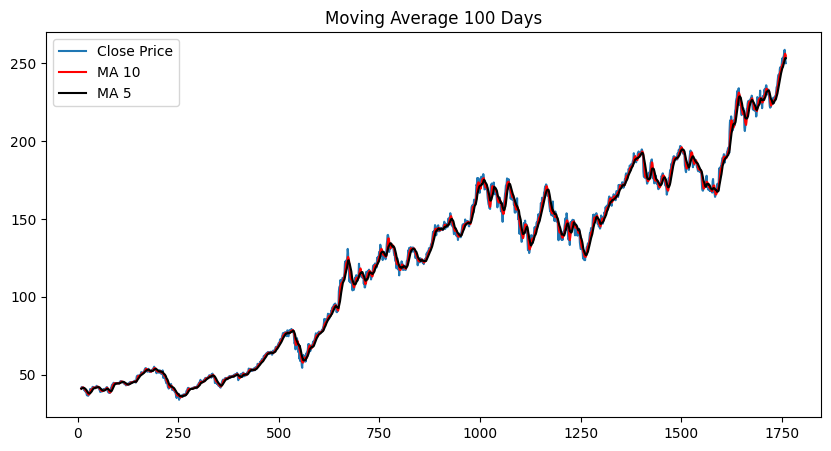

In [356]:
plt.figure(figsize=(10,5))
plt.title("Moving Average 100 Days")
plt.plot(df.Close, label="Close Price")
plt.plot(df.ma5, color='red', label="MA 10")
plt.plot(df.ma10, color='black', label="MA 5")

plt.legend()
plt.show()

In [357]:
def calculate_rsi(df, window=14):
    delta = df.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [358]:
df['rsi'] = calculate_rsi(df.Close).dropna()
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['high_low_ratio'] = df['High'] / df['Low']
df = df.iloc[14:].reset_index(drop=True)
df

Price,Date,Close,High,Low,Open,Volume,ma5,ma10,close_shifted,rsi,day_of_week,month,high_low_ratio
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
0,2018-02-05,36.774006,38.510602,36.658858,37.387337,290954000,38.499789,39.502503,37.716331,15.243331,0,2,1.050513
1,2018-02-06,38.310856,38.473001,36.188872,36.383917,272975200,38.314617,39.173280,36.774006,24.867080,1,2,1.063117
2,2018-02-07,37.490726,38.397798,37.380283,38.324951,206434400,37.943798,38.828310,38.310856,22.067927,2,2,1.027221
3,2018-02-08,36.459114,37.833823,36.430916,37.666976,217562000,37.350207,38.453262,37.490726,20.030780,3,2,1.038509
4,2018-02-09,36.905064,37.254270,35.449248,37.060792,282690400,37.187953,38.113409,36.459114,24.633265,4,2,1.050918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,252.881967,251.014017,254.989655,76.180657,1,12,1.011438
1734,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,255.073553,252.265639,257.916443,76.812079,3,12,1.009587
1735,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,256.232281,253.027800,258.735504,69.300685,4,12,1.022287


In [359]:
features = ['Close','ma5', 'close_shifted', 'day_of_week', 'month', 'high_low_ratio', 'rsi']
df = df.set_index(df['Date'])

In [380]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_value = scaler.fit_transform(df[features].dropna())
df_scaled = pd.DataFrame(data=scaled_value,index=df.index, columns=features)
df_scaled.shape

(1738, 7)

In [381]:
def create_sequences(df, sequence_length):
    x_data = []
    y_data = []
    
    for i in range(sequence_length, df_scaled.shape[0]):
        x_data.append(df.iloc[i-sequence_length:i].values) 
        y_data.append(df.iloc[i].values)

    return np.array(x_data), np.array(y_data)

sequence_length = 21
x, y = create_sequences(df_scaled, sequence_length)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, 
y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((1373, 21, 7), (344, 21, 7))

In [386]:
num_hidden_layers = [1, 2]
num_neurons = [50,60,80]
dropout_pct = 0.3

In [ ]:
model =  Sequential()

if num_hidden_layers == 1:
    model.add(LSTM(num_neurons, activation='tanh', input_shape = (x_train.shape[1], len(features))))
        
else:
    for num in range(2):
        model.add(LSTM(num_neurons,activation='tanh', input_shape =(x_train.shape[1], len(features)), return_sequences=True))        
        model.add(LSTM(num_neurons))


model.add(Dense(1))
model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
    #prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0,
                                restore_best_weights=True, mode='min')

model.fit(x_train, y_train, epochs=50, batch_size=128, callbacks = [early_stopping],
                validation_data=(x_test, y_test), verbose=0, shuffle=False)

TypeError: '<=' not supported between instances of 'list' and 'int'

In [391]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(x_train.shape[1], len(features))))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))

model.add(LSTM(units=100, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - loss: 0.1585 - val_loss: 0.0718 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0767 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0730 - val_loss: 0.0712 - learning_rate: 0.0010
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0723 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0708
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.0708 - val_loss: 0.0708 - learning_rate: 0.0010
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0708 - val_loss: 0.0697 - learning_rate: 5.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0725 - val_loss: 0.0699 - learning_rate: 5.0000e-04
Epoch 8/50
17/22 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0715

KeyboardInterrupt: 

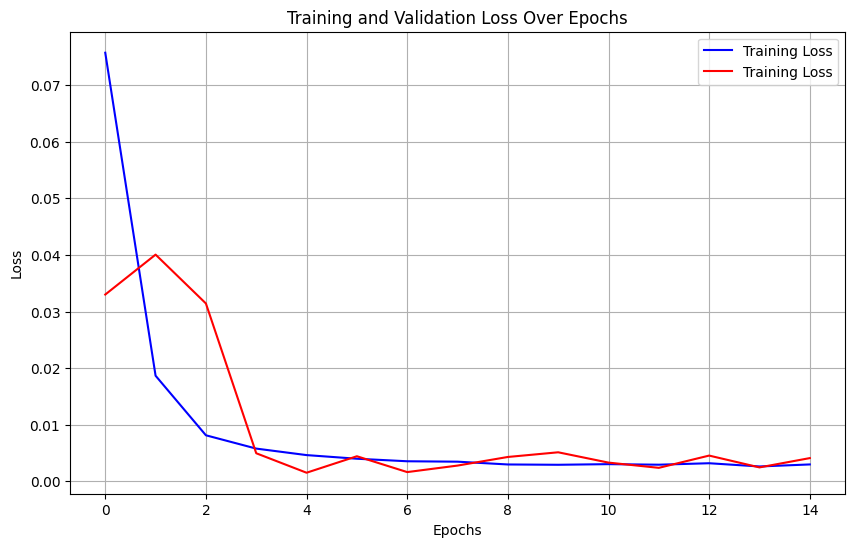

In [365]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Training Loss', color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
predictions = model.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


In [ ]:
# Faire des prédictions sur l'ensemble de test
predictions = model.predict(x_test)

# Inverser la normalisation des prédictions
predicted_values = np.zeros(shape=(len(predictions), len(features)))
predicted_values[:, 0] = predictions.flatten()
predicted_values = scaler.inverse_transform(predicted_values)
predicted_close = predicted_values[:, 0]

# Inverser la normalisation des valeurs réelles
actual_values = np.zeros(shape=(len(y_test), len(features)))
actual_values[:, 0] = y_test.flatten()
actual_values = scaler.inverse_transform(actual_values)
actual_close = actual_values[:, 0]

# Créer un DataFrame pour afficher les valeurs réelles et les prédictions
import pandas as pd

results = pd.DataFrame({
    'Date': df['Date'].iloc[-len(y_test):].values,  # Dates correspondantes
    'Valeurs Réelles': actual_close,
    'Prédictions': predicted_close
})

print("Valeurs Réelles vs Prédictions :")
print(results)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Valeurs Réelles vs Prédictions :
          Date  Valeurs Réelles  Prédictions
0   2023-12-05       192.265671   189.775594
1   2023-12-06       191.172226   190.219815
2   2023-12-07       193.110580   190.535835
3   2023-12-08       194.541992   190.864599
4   2023-12-11       192.027100   191.291024
..         ...              ...          ...
265 2024-12-24       257.916443   265.244474
266 2024-12-26       258.735504   266.536962
267 2024-12-27       255.309296   267.823528
268 2024-12-30       251.923019   269.218878
269 2024-12-31       250.144974   270.223018

[270 rows x 3 columns]


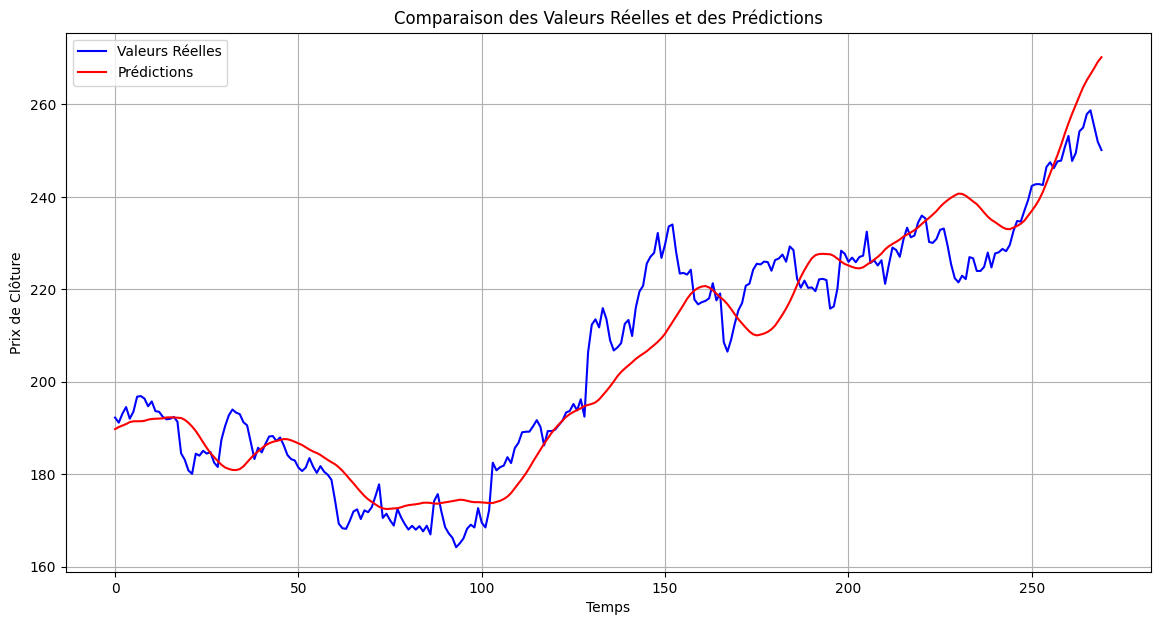

In [ ]:
import matplotlib.pyplot as plt

# Tracer les valeurs réelles et les prédictions
plt.figure(figsize=(14, 7))
plt.plot(actual_close, color='blue', label='Valeurs Réelles')
plt.plot(predicted_close, color='red', label='Prédictions')
plt.title('Comparaison des Valeurs Réelles et des Prédictions')
plt.xlabel('Temps')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.grid(True)
plt.show()